In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
import lingam
from lingam import DirectLiNGAM
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from cdt.metrics import SHD
from sklearn.metrics import precision_score, recall_score, f1_score
from causallearn.utils.GraphUtils import GraphUtils
from scipy.stats import skew, kurtosis







df = pd.read_csv('CNC_Machine.csv')
df_clean = df.drop(columns=["Unnamed: 0", "filename", "start_time", "end_time", "edge", "meterID"])
df_clean.fillna(df_clean.median(), inplace=True)



No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


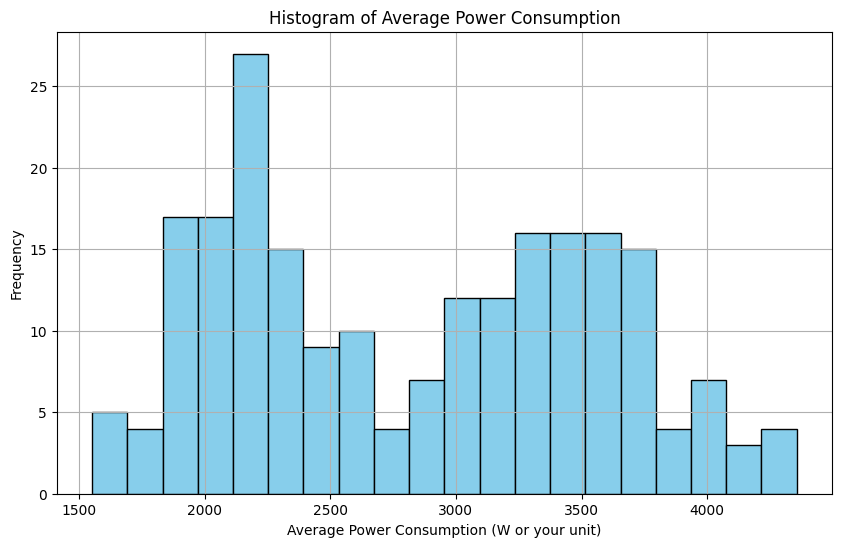

In [2]:
plt.figure(figsize=(10, 6))
plt.hist(df['average_power_consumption'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Average Power Consumption')
plt.xlabel('Average Power Consumption (W or your unit)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

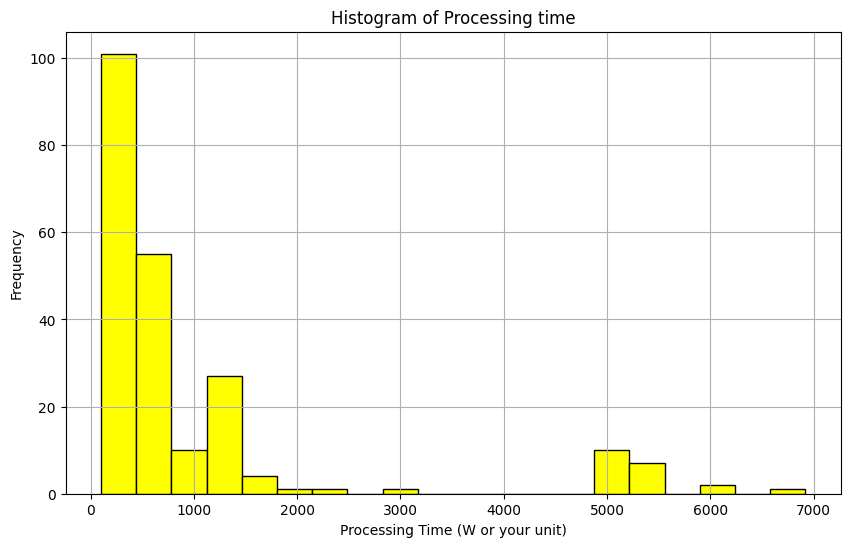

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(df['processing_time'], bins=20, color='yellow', edgecolor='black')
plt.title('Histogram of Processing time')
plt.xlabel('Processing Time (W or your unit)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

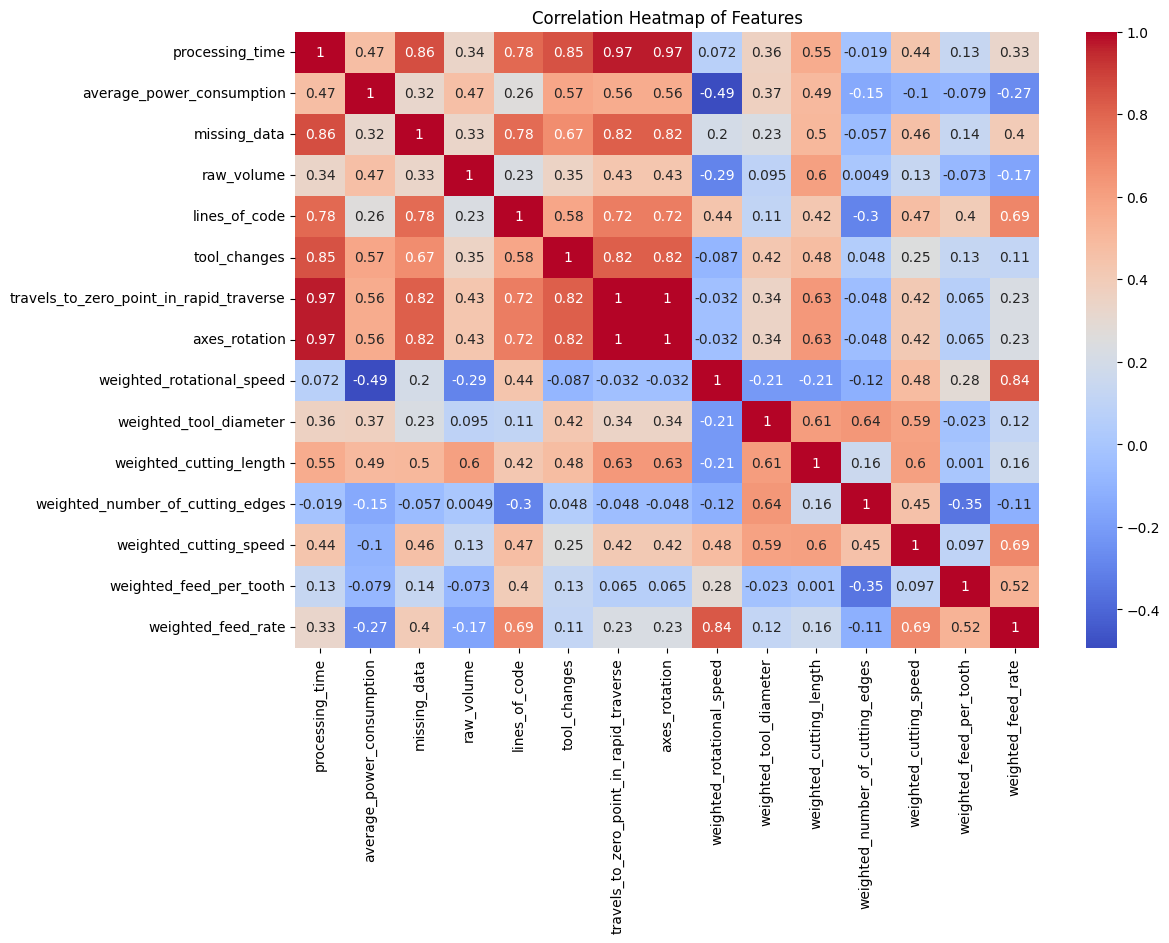

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()


In [5]:
for col in df_clean.select_dtypes(include=np.number).columns:
    print(f"{col} — Skewness: {skew(df_clean[col]):.2f}, Kurtosis: {kurtosis(df_clean[col]):.2f}")

processing_time — Skewness: 2.48, Kurtosis: 4.97
average_power_consumption — Skewness: 0.13, Kurtosis: -1.27
missing_data — Skewness: 2.54, Kurtosis: 7.45
raw_volume — Skewness: -0.34, Kurtosis: -1.88
lines_of_code — Skewness: 1.32, Kurtosis: 0.64
tool_changes — Skewness: 1.56, Kurtosis: 1.41
travels_to_zero_point_in_rapid_traverse — Skewness: 2.27, Kurtosis: 4.04
axes_rotation — Skewness: 2.27, Kurtosis: 4.04
weighted_rotational_speed — Skewness: -0.46, Kurtosis: 0.00
weighted_tool_diameter — Skewness: -0.45, Kurtosis: -0.72
weighted_cutting_length — Skewness: 0.05, Kurtosis: -1.12
weighted_number_of_cutting_edges — Skewness: -0.83, Kurtosis: 0.11
weighted_cutting_speed — Skewness: -0.21, Kurtosis: -0.98
weighted_feed_per_tooth — Skewness: 3.15, Kurtosis: 17.15
weighted_feed_rate — Skewness: -0.09, Kurtosis: -0.61


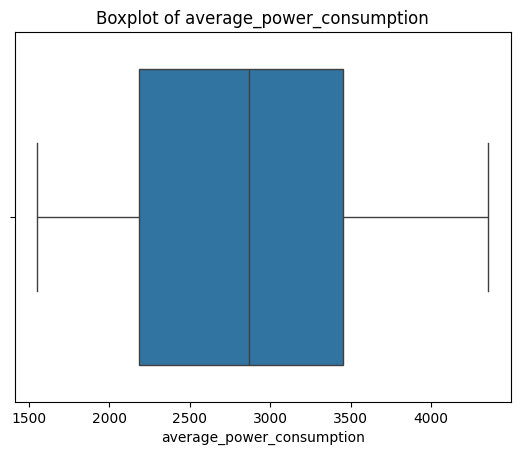

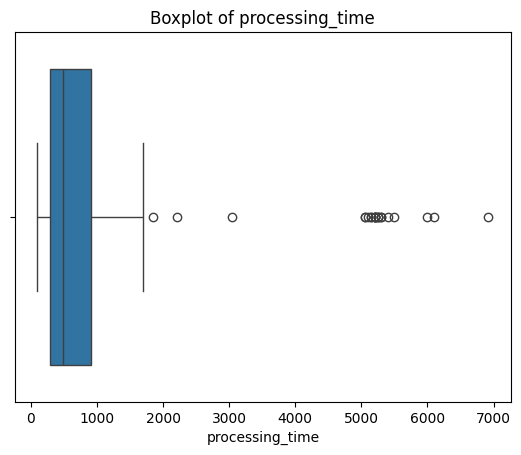

In [6]:
for col in ['average_power_consumption', 'processing_time']:
    sns.boxplot(data=df_clean, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()


In [7]:
target = "average_power_consumption"
X = df_clean.drop(columns=[target])
y = df_clean[target]
feature_names = df_clean.columns.tolist()



In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaler_y = MinMaxScaler(feature_range=(0, 1))  # Normalize between 0 and 1
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()




In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [10]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [11]:
class CNCCausalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.adjacency = nn.Parameter(torch.randn(input_dim, input_dim))  
        nn.init.xavier_uniform_(self.adjacency)  
        
        #Deeper network with more neurons
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.target_net = nn.Linear(64, 1)

    def forward(self, x):
        W = torch.sigmoid(self.adjacency) * (1 - torch.eye(self.adjacency.shape[0])) 
        masked_input = torch.matmul(x, W)
        shared = self.shared_net(masked_input)
        return self.target_net(shared)


In [12]:
model = CNCCausalModel(X_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

criterion = nn.HuberLoss(delta=1.0)  


In [13]:
# X_tensor = torch.FloatTensor(X_scaled)
# y_tensor = torch.FloatTensor(y_scaled)

In [14]:
loss_values = []
dag_values = []
for epoch in range(3000):  
    optimizer.zero_grad()
    
    pred = model(X_train_tensor)
    loss = criterion(pred, y_train_tensor)
    
    
    W = torch.sigmoid(model.adjacency)
    h = torch.trace(torch.matrix_exp(W * W)) - W.shape[0]

    loss += 0.1 * h * h  
    
    loss += 0.1 * torch.norm(model.adjacency, p=1)


    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    dag_values.append(h.item())

    # if epoch % 500 == 0:
    #     print(f"Epoch {epoch}: Loss={loss.item():.6f}, DAG Loss={h.item():.6f}")


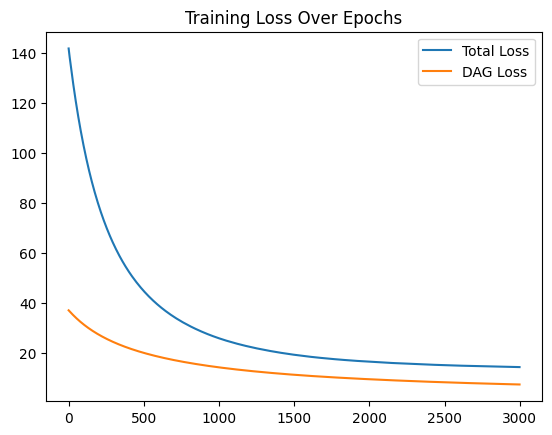

In [15]:
plt.plot(loss_values, label="Total Loss")
plt.plot(dag_values, label="DAG Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    adj_matrix = torch.sigmoid(model.adjacency).numpy()
    
    W_val = torch.sigmoid(model.adjacency)
    h_val = torch.trace(torch.matrix_exp(W_val * W_val)) - W_val.shape[0]
    


y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))


In [17]:
print("y mean:", y.mean(), "y std:", y.std())
print("y_scaled mean:", y_scaled.mean(), "y_scaled std:", y_scaled.std())


y mean: 2835.3724582008444 y std: 720.7970690058299
y_scaled mean: 0.457528488253665 y_scaled std: 0.2565619710294054


In [18]:
print("y mean:", y.mean(), "y std:", y.std())
print("y_scaled mean:", y_scaled.mean(), "y_scaled std:", y_scaled.std())


y mean: 2835.3724582008444 y std: 720.7970690058299
y_scaled mean: 0.457528488253665 y_scaled std: 0.2565619710294054


In [19]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"R²: {r2:.3f}, MAE: {mae:.2f} kW")

R²: 0.910, MAE: 163.00 kW


In [20]:
feature_names = [col for col in df_clean.columns if col != target]
print("Features:", feature_names)
print("Number of features:", len(feature_names))

Features: ['processing_time', 'missing_data', 'raw_volume', 'lines_of_code', 'tool_changes', 'travels_to_zero_point_in_rapid_traverse', 'axes_rotation', 'weighted_rotational_speed', 'weighted_tool_diameter', 'weighted_cutting_length', 'weighted_number_of_cutting_edges', 'weighted_cutting_speed', 'weighted_feed_per_tooth', 'weighted_feed_rate']
Number of features: 14


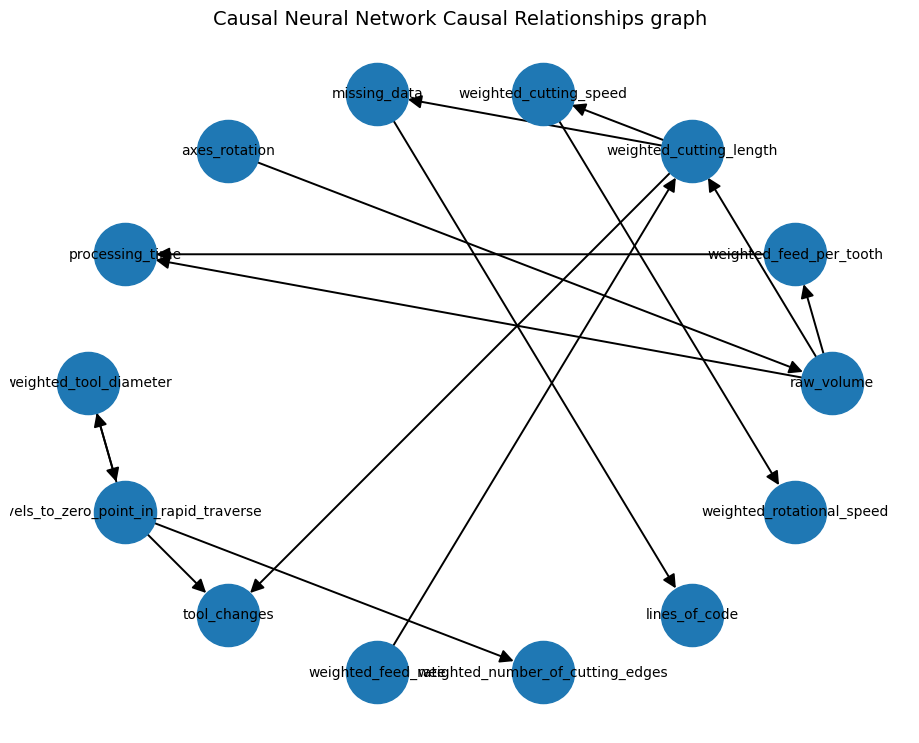

In [21]:
def get_top_k_edges(adj_matrix, feature_names, k=15):
    edges = []
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            if i != j:
                weight = adj_matrix[i, j]
                edges.append((feature_names[i], feature_names[j], weight))
    # edges.sort(key=lambda x: x[2], reverse=True)
    edges.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)
    return edges[:k]

G = nx.DiGraph()
top_edges = get_top_k_edges(adj_matrix, feature_names, k=15)
for src, tgt, weight in top_edges:
    G.add_edge(src, tgt, weight=weight)

plt.figure(figsize=(9, 7))
# pos = nx.spring_layout(G, k=0.7, seed=42)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, 
        node_size=2000,
        width=[G[u][v]['weight']*3 for u, v in G.edges],
        arrowsize=20,
        font_size=10)
plt.title("Causal Neural Network Causal Relationships graph", fontsize=14)
plt.show()

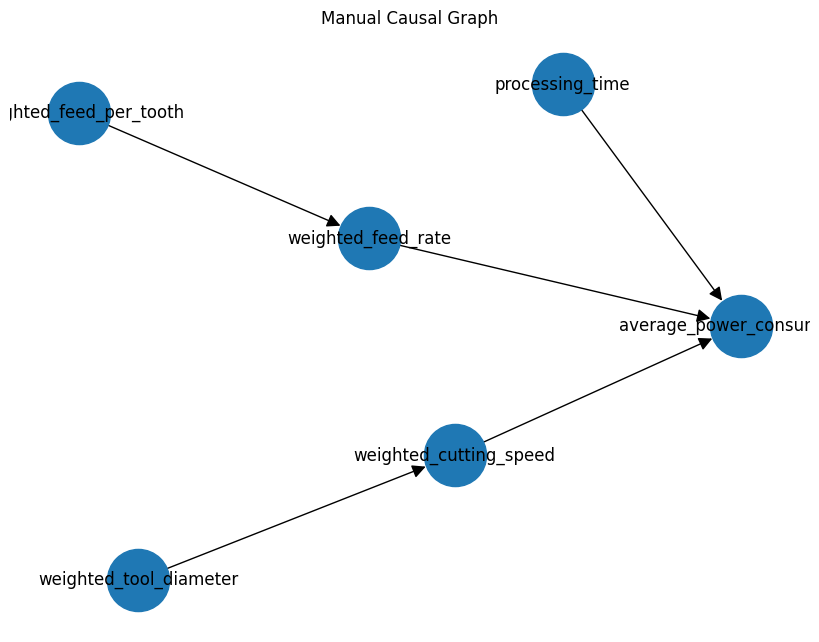

In [22]:

manual_edges = [
    ("processing_time", "average_power_consumption"),
    ("weighted_cutting_speed", "average_power_consumption"),
    ("weighted_feed_rate", "average_power_consumption"),
    ("weighted_tool_diameter", "weighted_cutting_speed"),
    ("weighted_feed_per_tooth", "weighted_feed_rate"),
]

# Create the manual causal graph
G_manual = nx.DiGraph()
G_manual.add_edges_from(manual_edges)


plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_manual, seed=42)
nx.draw(G_manual, pos, with_labels=True, node_size=2000, arrowsize=20)
plt.title("Manual Causal Graph")
plt.show()



In [23]:
feature_importance = adj_matrix.mean(axis=1)  
results = pd.DataFrame({
    'Feature': feature_names,
    'Causal_Weight': feature_importance
}).sort_values('Causal_Weight', key=abs, ascending=False)

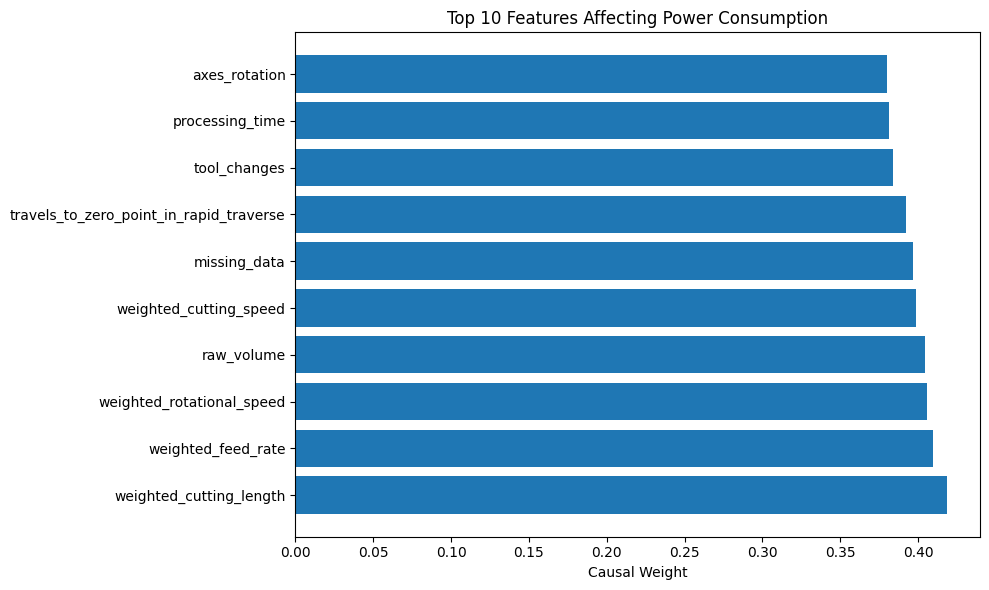

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(results['Feature'].head(10), results['Causal_Weight'].head(10))
plt.xlabel('Causal Weight')
plt.title('Top 10 Features Affecting Power Consumption')
plt.tight_layout()
plt.show()

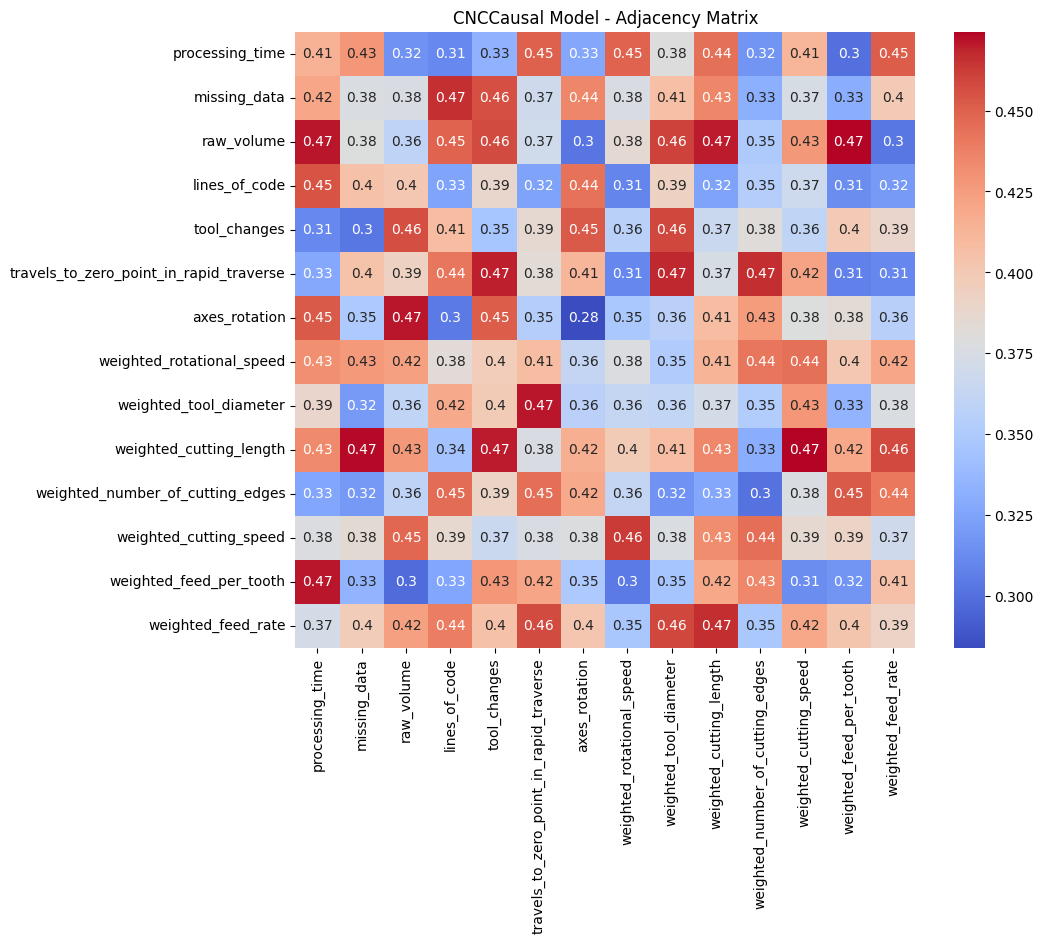

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, xticklabels=feature_names, yticklabels=feature_names, cmap="coolwarm", annot=True)
plt.title("CNCCausal Model - Adjacency Matrix")
plt.show()

In [26]:
ground_truth_graph = nx.DiGraph([
   ("processing_time", "average_power_consumption"),
    ("weighted_cutting_speed", "average_power_consumption"),
    ("weighted_feed_rate", "average_power_consumption"),
    ("weighted_tool_diameter", "weighted_cutting_speed"),
    ("weighted_feed_per_tooth", "weighted_feed_rate"),
])

In [27]:
true_edge_count = len(ground_truth_graph.edges())
top_edges = get_top_k_edges(adj_matrix, feature_names, k=true_edge_count)
G = nx.DiGraph()
for src, tgt, weight in top_edges:
    G.add_edge(src, tgt, weight=weight)


target = "average_power_consumption"
if target not in G.nodes():
    G.add_node(target)
if target not in ground_truth_graph.nodes():
    ground_truth_graph.add_node(target)


# true_edges = ground_truth_graph.edges()
# pred_edges = G.edges()


In [28]:
def calculate_edge_metrics(true_edges, pred_edges):
    """Compute precision, recall, F1 for edges."""
    true_edges = set(true_edges)
    pred_edges = set(pred_edges)
    
    nodes = sorted(list(set([n for edge in true_edges | pred_edges for n in edge])))
    n = len(nodes)
    true_mat = np.zeros((n, n))
    pred_mat = np.zeros((n, n))
    
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    for src, tgt in true_edges:
        true_mat[node_to_idx[src], node_to_idx[tgt]] = 1
        
    for src, tgt in pred_edges:
        if src in node_to_idx and tgt in node_to_idx:  
            pred_mat[node_to_idx[src], node_to_idx[tgt]] = 1
    
    true_flat = true_mat.flatten()
    pred_flat = pred_mat.flatten()
    
    precision = precision_score(true_flat, pred_flat,  zero_division=0)
    recall = recall_score(true_flat, pred_flat,  zero_division=0)
    f1 = f1_score(true_flat, pred_flat,  zero_division=0)
    
    return precision, recall, f1

true_edges = ground_truth_graph.edges()
pred_edges = G.edges()
# true_edges = {(src.lower(), tgt.lower()) for src, tgt in ground_truth_graph.edges()}
# pred_edges = {(src.lower(), tgt.lower()) for src, tgt in G.edges()}

precision, recall, f1 = calculate_edge_metrics(true_edges, pred_edges)

common_nodes = set(ground_truth_graph.nodes()) & set(G.nodes())

true_subgraph = ground_truth_graph.subgraph(common_nodes).copy()
pred_subgraph = G.subgraph(common_nodes).copy()

shd_value = SHD(true_subgraph, pred_subgraph)

print("\nCausal Graph Metrics:")
print(f"- Precision: {precision:.3f} (Fraction of predicted edges that are correct)")
print(f"- Recall: {recall:.3f} (Fraction of true edges recovered)")
print(f"- F1: {f1:.3f} (Harmonic mean of precision/recall)")
print(f"- SHD: {shd_value} (Structural Hamming Distance - computed on common nodes only)")

print("\nPredictive Metrics:")
print(f"- R²: {r2_score(y_test_rescaled, y_pred_rescaled):.3f}")
print(f"- MAE: {mean_absolute_error(y_test_rescaled, y_pred_rescaled):.2f} kW")


Causal Graph Metrics:
- Precision: 0.000 (Fraction of predicted edges that are correct)
- Recall: 0.000 (Fraction of true edges recovered)
- F1: 0.000 (Harmonic mean of precision/recall)
- SHD: 3 (Structural Hamming Distance - computed on common nodes only)

Predictive Metrics:
- R²: 0.910
- MAE: 163.00 kW


In [29]:
print(f"True Edges: {true_edges}")
print(f"Predicted Edges: {pred_edges}")


True Edges: [('processing_time', 'average_power_consumption'), ('weighted_cutting_speed', 'average_power_consumption'), ('weighted_feed_rate', 'average_power_consumption'), ('weighted_tool_diameter', 'weighted_cutting_speed'), ('weighted_feed_per_tooth', 'weighted_feed_rate')]
Predicted Edges: [('raw_volume', 'weighted_feed_per_tooth'), ('weighted_feed_per_tooth', 'processing_time'), ('weighted_cutting_length', 'weighted_cutting_speed'), ('weighted_cutting_length', 'missing_data'), ('axes_rotation', 'raw_volume')]


In [30]:
missing_edges = set(ground_truth_graph.edges()) - set(G.edges())
print("Missing True Edges:", missing_edges)



Missing True Edges: {('weighted_feed_rate', 'average_power_consumption'), ('weighted_cutting_speed', 'average_power_consumption'), ('weighted_tool_diameter', 'weighted_cutting_speed'), ('processing_time', 'average_power_consumption'), ('weighted_feed_per_tooth', 'weighted_feed_rate')}


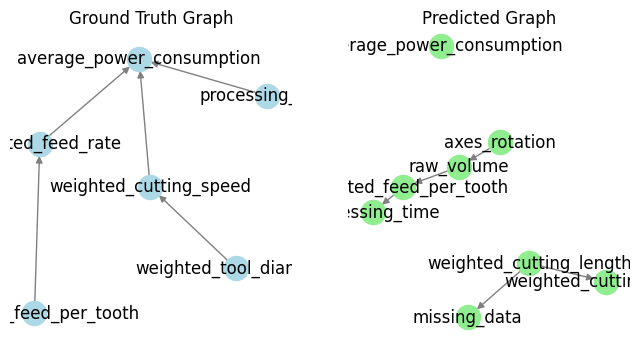

In [31]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
nx.draw(ground_truth_graph, with_labels=True, node_color="lightblue", edge_color="gray")
plt.title("Ground Truth Graph")

plt.subplot(1, 2, 2)
nx.draw(G, with_labels=True, node_color="lightgreen", edge_color="gray")
plt.title("Predicted Graph")

plt.show()


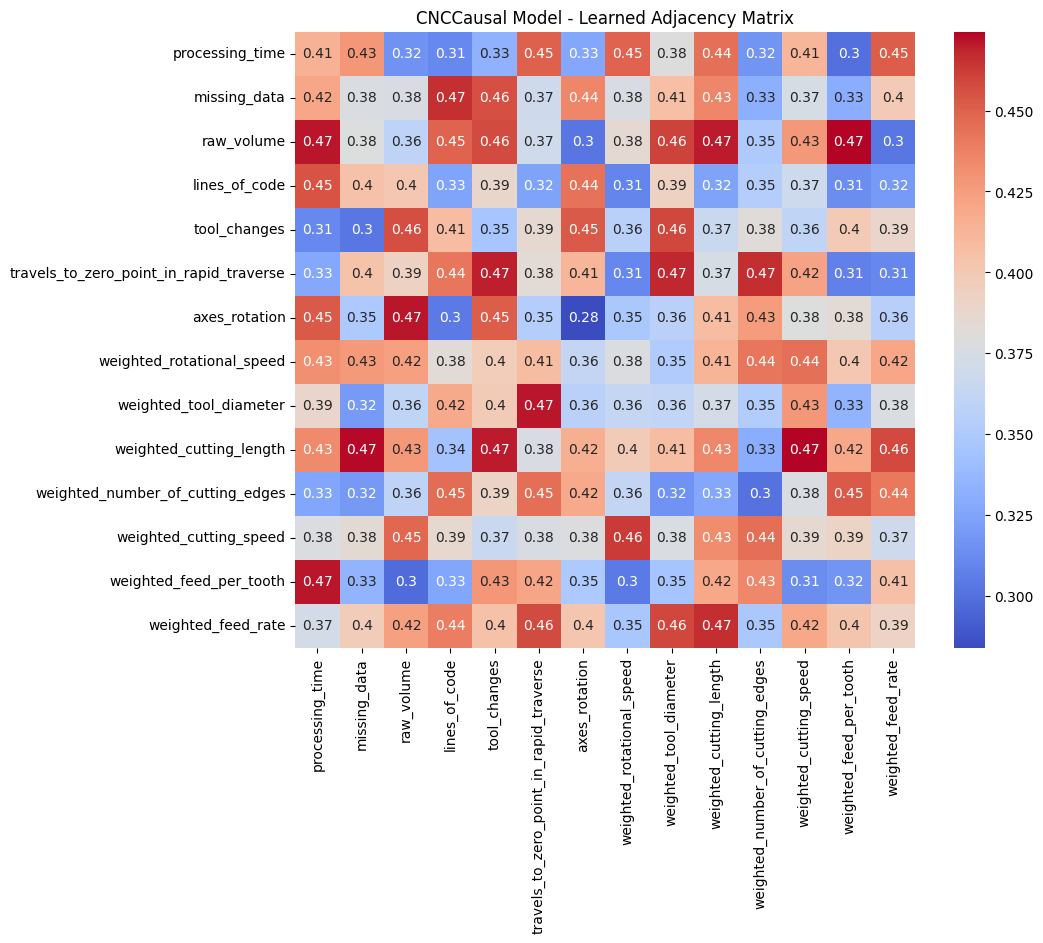

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(adj_matrix, xticklabels=feature_names, yticklabels=feature_names, cmap="coolwarm", annot=True)
plt.title("CNCCausal Model - Learned Adjacency Matrix")
plt.show()


In [33]:
print("\nGround Truth Graph Edges:", list(ground_truth_graph.edges()))
print("\nPredicted Graph Edges:", list(G.edges()))


Ground Truth Graph Edges: [('processing_time', 'average_power_consumption'), ('weighted_cutting_speed', 'average_power_consumption'), ('weighted_feed_rate', 'average_power_consumption'), ('weighted_tool_diameter', 'weighted_cutting_speed'), ('weighted_feed_per_tooth', 'weighted_feed_rate')]

Predicted Graph Edges: [('raw_volume', 'weighted_feed_per_tooth'), ('weighted_feed_per_tooth', 'processing_time'), ('weighted_cutting_length', 'weighted_cutting_speed'), ('weighted_cutting_length', 'missing_data'), ('axes_rotation', 'raw_volume')]


In [34]:
# print("Adjacency Matrix Values:")
# for i, feature in enumerate(feature_names):
#     print(f"{feature}: {adj_matrix[i]}")


In [35]:
top_features = sorted(zip(feature_names, adj_matrix.mean(axis=1)), key=lambda x: x[1], reverse=True)
print("Top Influential Features:")
for feature, score in top_features[:10]:  # Adjust number of features displayed
    print(f"{feature}: {score:.3f}")


Top Influential Features:
weighted_cutting_length: 0.419
weighted_feed_rate: 0.409
weighted_rotational_speed: 0.406
raw_volume: 0.404
weighted_cutting_speed: 0.399
missing_data: 0.397
travels_to_zero_point_in_rapid_traverse: 0.392
tool_changes: 0.384
processing_time: 0.381
axes_rotation: 0.380


In [36]:
def sensitivity_analysis(model, X_test_tensor, y_test_tensor, feature_names, perturbation_factor=0.05):

    sensitivity_scores = {}

    for idx, feature in enumerate(feature_names):
        perturbed_X_test = X_test_tensor.clone()
        
        
        perturbation = perturbation_factor * X_test_tensor[:, idx].mean()
        perturbed_X_test[:, idx] += perturbation

        
        with torch.no_grad():
            original_pred = model(X_test_tensor)
            perturbed_pred = model(perturbed_X_test)

        
        change_in_prediction = torch.abs(perturbed_pred - original_pred).mean().item()

        sensitivity_scores[feature] = change_in_prediction

   
    sorted_sensitivity = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)

    return sorted_sensitivity


In [37]:
sensitivity_results = sensitivity_analysis(model, X_test_tensor, y_test_tensor, feature_names)

print("Feature Sensitivity Scores:")
for feature, score in sensitivity_results:
    print(f"{feature}: {score:.4f}")


Feature Sensitivity Scores:
weighted_number_of_cutting_edges: 0.0018
weighted_tool_diameter: 0.0005
weighted_feed_rate: 0.0004
missing_data: 0.0003
weighted_feed_per_tooth: 0.0003
lines_of_code: 0.0003
processing_time: 0.0003
weighted_rotational_speed: 0.0002
weighted_cutting_speed: 0.0002
travels_to_zero_point_in_rapid_traverse: 0.0002
axes_rotation: 0.0001
weighted_cutting_length: 0.0001
tool_changes: 0.0001
raw_volume: 0.0000


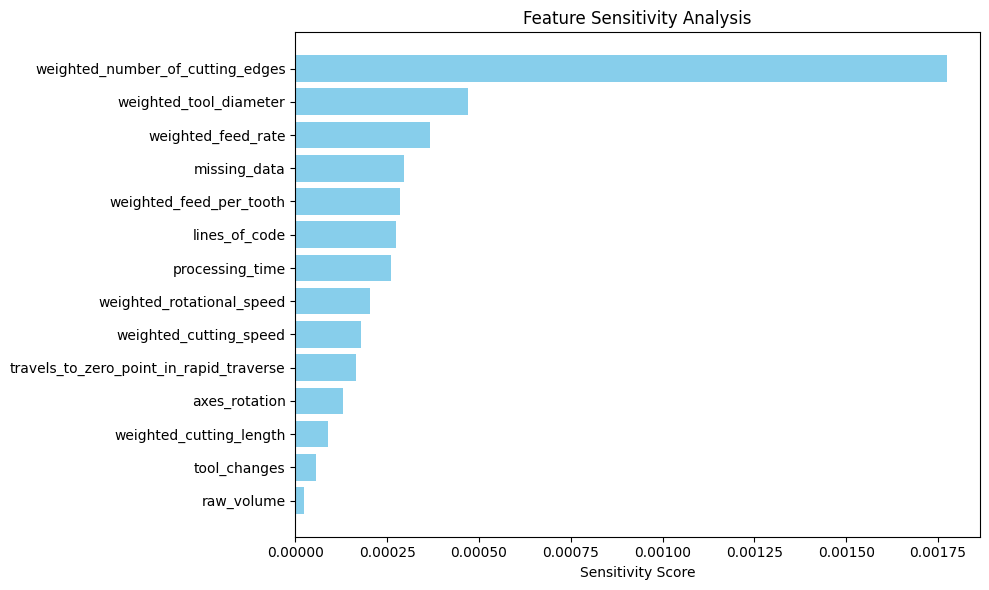

In [38]:
features, sensitivity = zip(*sensitivity_results)

plt.figure(figsize=(10, 6))
plt.barh(features, sensitivity, color='skyblue')
plt.xlabel("Sensitivity Score")
plt.title("Feature Sensitivity Analysis")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


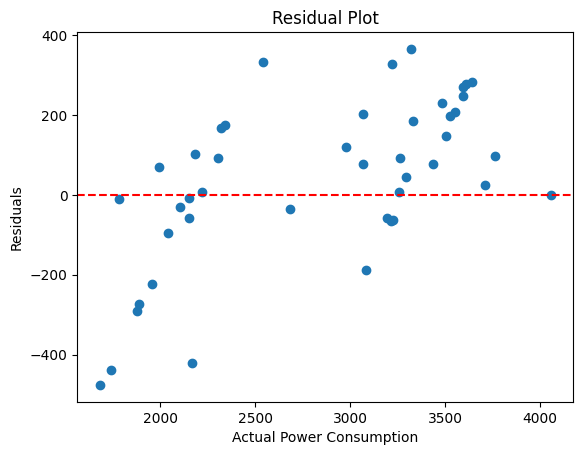

In [39]:
residuals = y_test_rescaled - y_pred_rescaled
plt.scatter(y_test_rescaled, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Power Consumption')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


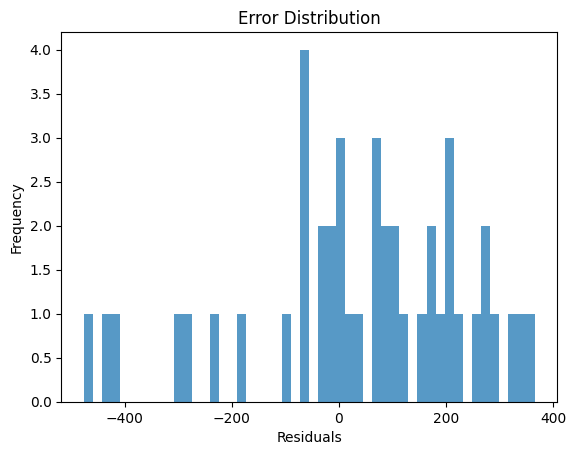

In [40]:
plt.hist(residuals, bins=50, alpha=0.75)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()


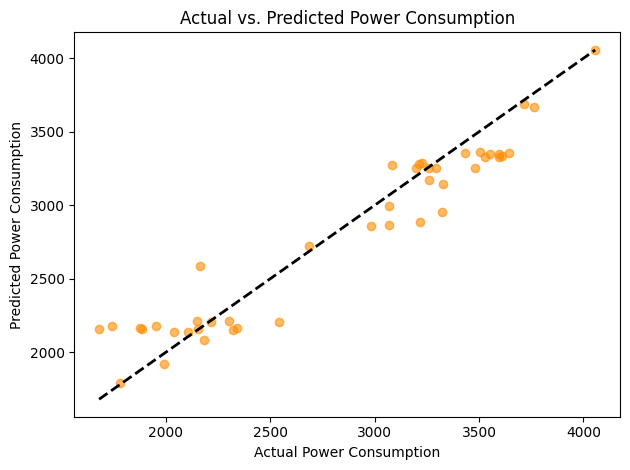

In [41]:
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6, color='darkorange')
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()],
         [y_test_rescaled.min(), y_test_rescaled.max()], 'k--', lw=2)
plt.xlabel("Actual Power Consumption")
plt.ylabel("Predicted Power Consumption")
plt.title("Actual vs. Predicted Power Consumption")
plt.tight_layout()
plt.show()
